In [194]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence
import operator
from pydantic import BaseModel , Field
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph,END
import requests
import json
import os
from langchain_core.runnables import RunnableLambda

load_dotenv()

True

In [195]:
HOROSCOPE_ENDPOINT = os.getenv('HOROSCOPE_ENDPOINT')
WEATHER_ENDPOINT = os.getenv('WEATHER_ENDPOINT')

In [196]:
# Step 1 - Define state class
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [197]:
# Step 2 - Load env and initialize the model
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [198]:
# Step 3 - Define output schema from the supervisor node
class TopicSelectionParser(BaseModel):
    Intent: str = Field(description='Intent of the question')
    Entities: dict[str, str] = Field(description='Entities in the question')
    Reasoning: str = Field(description='Reasoning behind topic selection')


In [199]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)


In [200]:
def node1(state: AgentState):
    print("\n--- Supervisor Node ---")
    question = state["messages"][-1]
    print("Question:", question)

    template = """
    Your task is to classify the given user query into one of the following Intent: [Horoscope, Weather, Not Related]. 
    Only respond with the intent name and nothing else. If there is intent name in the question, then return the intent name along with the entities.
    For Horoscope, the entities are zodiac_sign the value of it should start with capital letter eg: Libra. For Weather, the entities are location.
    {format_instructions}
    Question: {question}
    """
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain = prompt | model | parser
    response = chain.invoke({"question": question})
    response_dict = response.model_dump()
    response_dict["question"] = question
    # print("Parsed response:", response_dict)
    return {"messages": [response_dict]}


In [201]:
def router(state: AgentState):
    last_msg = state["messages"][-1]
    print("\n--- Router Debug ---")
    print("Last Message:", last_msg)

    intent = last_msg.get("Intent", "").lower()
    print("Detected Intent:", intent)

    if "horoscope" in intent:
        result = "Horoscope"
    elif "weather" in intent:
        result = "Weather"
    else:
        result = "LLM"

    print("Router returning:", repr(result), "| Type:", type(result))
    assert result in ["Horoscope", "Weather", "LLM"], "Router returned invalid path"
    return result


In [202]:
# Step 6 - LLM Node
def node2(state: AgentState):
    print("\n--- LLM Node ---")
    question = state["messages"][-1]["question"]
    complete_query = "Answer the following question using real-world knowledge: " + question
    response = model.invoke(complete_query)
    # Remove <think>...</think> and only return the final message
    content = response.content
    if "</think>" in content:
        content = content.split("</think>", 1)[-1].strip()
    return {"messages": [content]}


In [203]:
# # Step 7 - Horoscope Node
# def node3(state: AgentState):
#     print("\n--- Horoscope Node ---")
#     parsed_msg = state["messages"][-1]
#     question = parsed_msg.get("question", "")
#     sign = parsed_msg.get("Entities", {}).get("zodiac") or parsed_msg.get("Entities", {}).get("sign") or parsed_msg.get("Entities", {}).get("zodiac_sign")

#     if sign:
#         try:
#             url = f"{HOROSCOPE_ENDPOINT}&zodiac={sign}"
#             response = requests.get(url)
#             answer = response.json()  # Parse as JSON
#             print("Parsed answer:", answer)
#             # Defensive: check for 'data' and keys
#             if "data" in answer and answer["data"]:
#                 date = answer["data"].get("date", "")
#                 profession = answer["data"].get("profession", "")
#                 love = answer["data"].get("love", "")
#                 return {"messages": [f"Your horoscope prediction for {date} is: {profession} and {love}"]}
#             else:
#                 return {"messages": [f"Unexpected response format from horoscope API: {answer}"]}
#         except Exception as e:
#             answer = f"Failed to fetch horoscope data: {str(e)}"
#             return {"messages": [answer]}
#     else:
#         answer = "Zodiac sign not found."
#         return {"messages": [answer]}

#     # complete_query = f"Make this user-friendly. Response: {answer}"
#     # response = model.invoke(complete_query)
#     # return {"messages": [response.content]}
#     # return {"messages": json.loads(answer)}


In [204]:
# def node3(state: AgentState):
#     print("\n--- Horoscope Node (via MCP) ---")
#     parsed_msg = state["messages"][-1]
#     question = parsed_msg.get("question", "")
#     sign = parsed_msg.get("Entities", {}).get("zodiac") or parsed_msg.get("Entities", {}).get("sign") or parsed_msg.get("Entities", {}).get("zodiac_sign")

#     if sign:
#         try:
#             payload = {
#                 "jsonrpc": "2.0",
#                 "id": 1,
#                 "method": "tools/call",
#                 "params": {
#                     "name": "get_horoscope",
#                     "arguments": {
#                         "zodiac_sign": sign,
#                         "horoscope_type": "DAILY"
#                     }
#                 }
#             }
#             headers = {
#                 "Content-Type": "application/json",
#                 "Accept": "application/json, text/event-stream"
#             }
#             response = requests.post("http://localhost:8001/mcp/", headers=headers, data=json.dumps(payload))
#             result = response.json()
            

#             print("MCP Horoscope Result:", result)

#             # Parse response
#             data = result.get("result", {})
#             date = data.get("date", "today")
#             profession = data.get("profession", "")
#             love = data.get("love", "")
#             return {"messages": [f"Your horoscope for {sign} on {date}:\n💼 Career: {profession}\n❤️ Love: {love}"]}
#         except Exception as e:
#             return {"messages": [f"Error while calling MCP Horoscope Tool: {str(e)}"]}
#     else:
#         return {"messages": ["Zodiac sign not found in your query. Please mention it like 'Libra', 'Gemini', etc."]}


In [205]:
async def node3(state: AgentState):
    print("\n--- Horoscope Node ---")
    parsed_msg = state["messages"][-1]
    question = parsed_msg.get("question", "")
    sign = parsed_msg.get("Entities", {}).get("zodiac") or \
           parsed_msg.get("Entities", {}).get("sign") or \
           parsed_msg.get("Entities", {}).get("zodiac_sign")

    if not sign:
        return {"messages": ["Zodiac sign not found."]}

    MCP_URL = "http://localhost:8001/mcp/"
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "tools/call",
        "params": {
            "name": "get_horoscope",
            "arguments": {
                "zodiac_sign": sign,
                "horoscope_type": "DAILY"
            }
        }
    }

    try:
        async with aiohttp.ClientSession() as session:
            async with session.post(MCP_URL, json=payload, headers={
                "Content-Type": "application/json",
                "Accept": "application/json, text/event-stream"
            }) as resp:
                if resp.status != 200:
                    return {"messages": [f"Failed to fetch horoscope. Status code: {resp.status}"]}

                async for line in resp.content:
                    decoded = line.decode("utf-8").strip()
                    if decoded.startswith("data:"):
                        json_data = decoded.replace("data:", "", 1).strip()
                        try:
                            result = json.loads(json_data)
                            print("Parsed MCP Result:", result)

                            if "result" in result:
                                content_list = result["result"].get("content", [])
                                if content_list and isinstance(content_list, list):
                                    full_text = content_list[0].get("text", "")
                                    return {"messages": [full_text]}
                                else:
                                    return {"messages": ["Horoscope content not found."]}
                            else:
                                return {"messages": [f"Unexpected response from MCP: {result}"]}
                        except json.JSONDecodeError as e:
                            return {"messages": [f"Error decoding JSON from stream: {e}"]}

                return {"messages": ["No data received from MCP stream."]}

    except Exception as e:
        return {"messages": [f"Error while calling MCP: {str(e)}"]}


In [206]:
# Step 8 - Weather Node
def node4(state: AgentState):
    print("\n--- Weather Node ---")
    parsed_msg = state["messages"][-1]
    question = parsed_msg.get("question", "")
    location = parsed_msg.get("Entities", {}).get("location")

    if location:
        try:
            url = f"{WEATHER_ENDPOINT}&q={location}&aqi=no"
            response = requests.get(url)
            answer = response.json()  # Parse as JSON
            print("Parsed weather answer:", answer)
            if "location" in answer and "current" in answer:
                loc_name = answer["location"].get("name", "")
                temp_c = answer["current"].get("temp_c", "")
                feelslike_c = answer["current"].get("feelslike_c", "")
                humidity = answer["current"].get("humidity", "")
                return {"messages": [f"Currently the weather in {loc_name} is {temp_c} degree celcius feels like {feelslike_c} degree celcius and humidity is {humidity} percent."]}
            else:
                return {"messages": [f"Unexpected response format from weather API: {answer}"]}
        except Exception as e:
            answer = f"Failed to fetch weather data: {str(e)}"
            return {"messages": [answer]}
    else:
        answer = "Location not found."
        return {"messages": [answer]}


In [207]:
workflow = StateGraph(AgentState)

workflow.add_node("Supervisor", node1)
workflow.add_node("LLM", node2)
workflow.add_node("Horoscope", RunnableLambda(node3))
workflow.add_node("Weather", node4)

workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
"Supervisor", 
router, {
    "Horoscope": "Horoscope",
    "Weather": "Weather",
    "LLM": "LLM"
})
workflow.add_edge("Horoscope", END)
workflow.add_edge("Weather", END)
workflow.add_edge("LLM", END)

In [208]:
# initial_state = AgentState(messages=[{
#     "question": "Libra horoscope for today",
#     "Intent": "Horoscope",
#     "Entities": {
#         "zodiac_sign": "Libra"
#     }
# }])

# # Compile and invoke the graph
# app = workflow.compile()
# final_state = await app.invoke(initial_state)
# print("Final Output:", final_state)

In [209]:
app = workflow.compile()

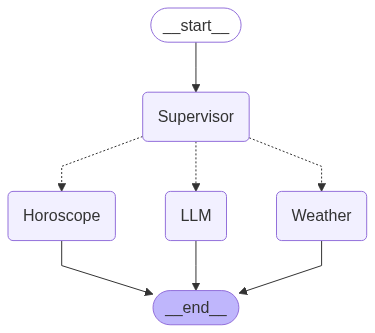

In [210]:
app

In [211]:
print("Registered nodes in the workflow:")
print(workflow.nodes.keys())

Registered nodes in the workflow:
dict_keys(['Supervisor', 'LLM', 'Horoscope', 'Weather'])


In [212]:
 await app.ainvoke({"messages": ["libra horoscope for today"]})


--- Supervisor Node ---
Question: libra horoscope for today

--- Router Debug ---
Last Message: {'Intent': 'Horoscope', 'Entities': {'zodiac_sign': 'Libra'}, 'Reasoning': "The question explicitly mentions 'horoscope' and 'libra', which are directly related to the Horoscope intent.", 'question': 'libra horoscope for today'}
Detected Intent: horoscope
Router returning: 'Horoscope' | Type: <class 'str'>

--- Horoscope Node ---
Parsed MCP Result: {'jsonrpc': '2.0', 'id': 1, 'result': {'content': [{'type': 'text', 'text': 'Horoscope for *Libra* (DAILY) on 2025-06-11:\n\nPersonal:\nToday might not be the best day for your love life. A fight has the potential to get ugly, but don’t worry, all will pass quickly.\n\nTravel:\nAre you fulfilled with your travel adventures this year? If not, now is the time to change that. \n\nLuck:\nRemember your special moments forever. They will give you a profound appreciation for your good fortune\n\nProfession:\nDon’t rush into combining your money with oth

{'messages': ['libra horoscope for today',
  {'Intent': 'Horoscope',
   'Entities': {'zodiac_sign': 'Libra'},
   'Reasoning': "The question explicitly mentions 'horoscope' and 'libra', which are directly related to the Horoscope intent.",
   'question': 'libra horoscope for today'},
  'Horoscope for *Libra* (DAILY) on 2025-06-11:\n\nPersonal:\nToday might not be the best day for your love life. A fight has the potential to get ugly, but don’t worry, all will pass quickly.\n\nTravel:\nAre you fulfilled with your travel adventures this year? If not, now is the time to change that. \n\nLuck:\nRemember your special moments forever. They will give you a profound appreciation for your good fortune\n\nProfession:\nDon’t rush into combining your money with others for a project. Make sure you have all the facts first.\n\nHealth:\nDon’t be too hard on yourself. The inner perfectionist in you needs to take a break every once in a while.\n\nEmotions:\nA small but seismic change is coming.']}